In [1]:
import numpy as np
import torch
from torchvision.utils import make_grid
from torch.autograd.functional import jacobian as jacobian
from loader.MNIST_dataset import MNIST_dataset
from models.ae import AE
from models.modules import FC_image

import matplotlib.pyplot as plt

# if you don't have gpu, 
# you can set device='cpu'
device = f'cuda:0'

- In this exercise, you will study how to analyze MNIST image data that approximately lies on some low-dimensional manifold. 
- Here, we assume the manifold's dimension is 2 for visualization purpose. 
- For simplicity, we use MNIST image of digits 0, 1, 2, 3, 4


1. Load Dataset (MNIST digits 0, 1, 2, 3, 4)

- The script below automatically downloads the MNIST image data in "datasets" directory.
- The image size is (1, 28, 28) which can be viewed as a data point living in $\mathbb{R}^{784}$.

In [2]:
train_ds = MNIST_dataset(root='datasets', split='training', digits=[0, 1, 2, 3, 4])

MNIST split training | torch.Size([25525, 1, 28, 28])


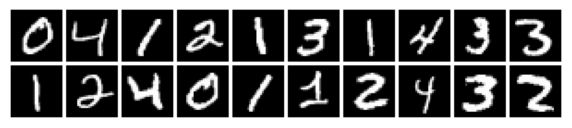

In [3]:
test_x = train_ds.data[:20]
x_img = make_grid(test_x, nrow=10, value_range=(0, 1), pad_value=1)

plt.figure(figsize=(10,10))
plt.imshow(x_img.permute(1,2,0))
plt.axis('off')
plt.show()

2. Load Pretrained Model

- You should download the pre-trained model "MNIST_digits_01234.pkl" from [HERE](https://drive.google.com/file/d/1nUB6IcvMFxEguH42ZmvamU2oY1iYHQKS/view?usp=sharing) and put it in the "pretrained/HW1/" directory. 
- The torch.nn.Module class "AE" has the two main methods "encode" and "decode", each of which corresponds to the encoder and decoder.

In [4]:
encoder = FC_image(in_chan=784, out_chan=2, l_hidden=[1024, 1024, ], activation=['elu', 'elu' ], out_activation='linear') 
decoder = FC_image(in_chan=2, out_chan=784, l_hidden=[1024, 1024, ], activation=['elu', 'elu' ], out_activation='sigmoid')

pretrained_model = AE(encoder, decoder)
pretrained_model.load_pretrained('pretrained/HW1/MNIST_digits_01234.pkl')
pretrained_model.to(device);

3. Visualize Embeddings

- Data points are mapped to the two-dimensioanl latent space (or coordinate space) by the encoder and visualized with label-coded colors.

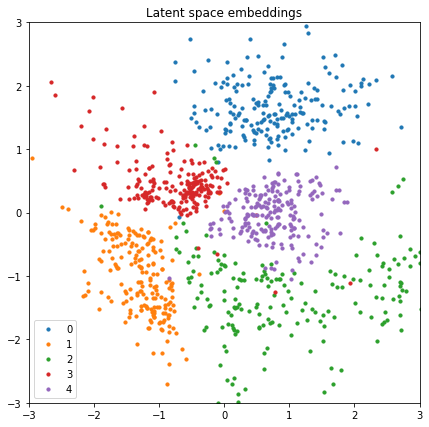

In [5]:
latent_embeddings = pretrained_model.encode(train_ds.data.to(device)).detach().cpu().numpy()

z_scale = np.minimum(
    np.max(latent_embeddings, axis=0), 
    np.min(latent_embeddings, axis=0)
)
labels = torch.unique(train_ds.targets)

f = plt.figure(figsize=(7, 7))
plt.title('Latent space embeddings')
for label in labels:
    classwise_le = latent_embeddings[train_ds.targets == label]
    plt.scatter(
        classwise_le[:200, 0], 
        classwise_le[:200, 1], 
        label=label.item(), s=10)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.legend()
plt.show()

### Problem

(a) Write the code for computing the Riemannian metric expressed in the latent space.

In [6]:
def get_Riemannian_metric(f, z, create_graph=False):
    '''
    f:      pretrained_model.decode
    z:      torch.tensor whose size = (n, 2)
    out:    torch.tensor whose size = (n, 2, 2)
    '''
    ##############################################
    ############### YOUR CODE HERE ###############
    ##############################################
    out = None
    #print(z, z.shape)
    for idx, ze in enumerate(z):
        mygrad = jacobian(f,ze)
        mygrad = torch.flatten(mygrad, start_dim =1 , end_dim = 3)
        cur_out = torch.bmm(torch.transpose(mygrad,1,2),mygrad)
        if idx == 0:
            out = cur_out
        else:
            out = torch.cat((out,cur_out))
    return out

- Your function "get_Riemannian_metric" should pass the below test code.

In [7]:
test_z = torch.randn(100, 2).to(device)

G = get_Riemannian_metric(pretrained_model.decode, test_z)
assert (G.size() == torch.Size([100, 2, 2]))

rand_v = torch.randn(100, 2).to(device)
assert torch.einsum('ni, nij, nj -> n', rand_v, G, rand_v).min().item() > 0

- With the "get_Riemannian_metric" function that you wrote, the below code will visualize the Riemannian metrics evaluated at some randomly selected points as equidistant ellipses, where the equidistant ellipse is defined as follows: given a Riemannian metric $G(z)$ at $z$, the equidistant ellipse at $z$ is a set $\{z' \ | \ (z'-z)^T G(z) (z'-z) = c\}$ for some constant $c>0$.  

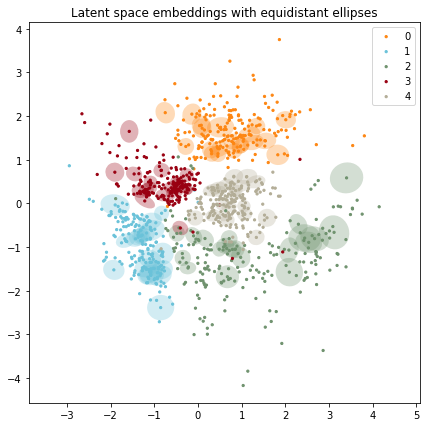

In [8]:
from utils import visualize_Riemannian_metric_as_ellipses

seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
    
visualize_Riemannian_metric_as_ellipses(
    train_ds, 
    pretrained_model, 
    get_Riemannian_metric, 
    device)

Q1) Can you interpret this result?

A1) We can verify that for the shape and size of the elipsoids are different from point to point, this is because we have measured Riemann metric locally with gradient of mapping. If the size of the elipsoids are large, it means that function doesn't vary much along that elipsoids.

- Now let's select class boundary points and visualize equidistant ellipses there.

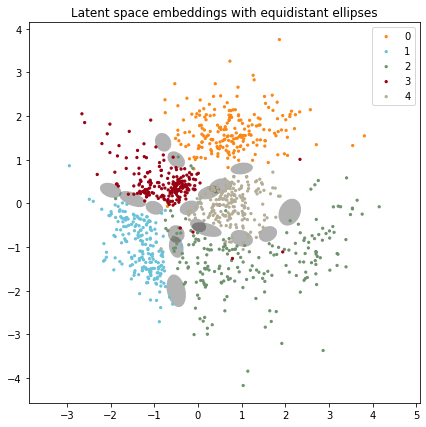

In [9]:
bd_points = torch.tensor([
    [-2, 0.3],
    [-1.5, 0.1],
    [-1, -0.1],
    [-0.5, -0.7],
    [-0.5, -1],
    [-0.5, -2],
    [0, -0.5],
    [0.2, -0.6],
    [1, -0.8],
    [1.6, -0.7],
    [2.1, -0.2],
    [-0.2, -0.1],
    [0.25, 0.25],
    [0.5, 0.4],
    [1, 0.8],
    [-0.5, 1],
    [-0.8, 1.4],
    ], dtype=torch.float32).to(device)

visualize_Riemannian_metric_as_ellipses(
    train_ds, 
    pretrained_model, 
    get_Riemannian_metric, 
    device,
    at=bd_points)

Q2) In which directions are the ellipses longer? Can you interpret this result?

We can verify that the direction along the boundaries are longer compared to the perpendicular axis. This is because a function varies 'lot' when latent vector moves perpendicular to boundary.

(b) Write the code for computing the legnth of a curve $z(t) \in \mathbb{R}^{2}$ for $t\in[0,1]$ which corresponds to a curve on the two-dimensional MNIST data manifold, by using the "get_Riemannian_metric" function.

In [10]:
def compute_length_of_curve(curve, pretrained_model, get_Riemannian_metric):
    '''
    curve:  torch.tensor whose size = (L, 2)
    out:    torch.tensor whose size = (1)
    '''
    
    ##############################################
    ############### YOUR CODE HERE ###############
    ##############################################
    # Get DZ
    dz = torch.zeros_like(curve)
    for idx, z in enumerate(curve):
        if idx > 0:
            dz[idx] = curve[idx] - curve[idx-1]
    # Calculate Curve
    #print(dz)
    G = get_Riemannian_metric(pretrained_model.decode, curve)
    out = torch.matmul(G, torch.unsqueeze(dz,2))
    out = torch.matmul(torch.unsqueeze(dz,1),out)
    out = torch.sum(torch.sqrt(out))
    return out

- Your function should pass the below test code.

In [11]:
x1 = test_x[0:1]
x2 = test_x[1:2]

z1 = pretrained_model.encode(x1.to(device))
z2 = pretrained_model.encode(x2.to(device))

list_len = []
for num_discretization in [100, 1000]:
    z_curve = torch.cat([z1 + (z2 - z1) * t/(num_discretization-1) for t in range(num_discretization)], dim=0)
    L = compute_length_of_curve(z_curve, pretrained_model, get_Riemannian_metric).item()
    list_len.append(L)
print(list_len)
assert ((list_len[0] - list_len[1])/list_len[0] < 0.1)

[33.98851776123047, 33.94548034667969]


- Now, you will compare the lengths of two curves whose lengths are same in the latent space.
- Below, the red and green squares correspond to digit 2 images and the blue square corresponds to digit 4 image.

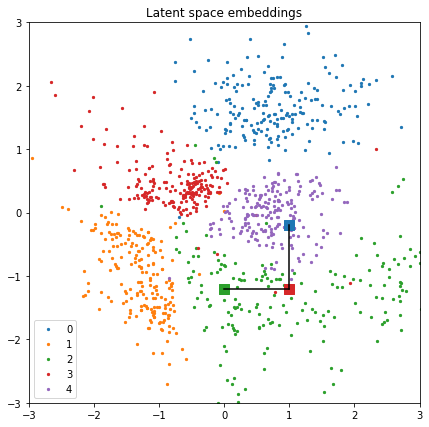

In [12]:
z1 = torch.tensor([[1, -1.2]], dtype=torch.float32) # digit 2 (red)
z2 = torch.tensor([[0, -1.2]], dtype=torch.float32) # digit 2 (green)
z3 = torch.tensor([[1, -0.2]], dtype=torch.float32) # digit 4 (blue)

latent_embeddings = pretrained_model.encode(
    train_ds.data.to(device)
    ).detach().cpu().numpy()

z_scale = np.minimum(
    np.max(latent_embeddings, axis=0), 
    np.min(latent_embeddings, axis=0)
)
labels = torch.unique(train_ds.targets)

f = plt.figure(figsize=(7, 7))
plt.title('Latent space embeddings')
for label in labels:
    classwise_le = latent_embeddings[train_ds.targets == label]
    plt.scatter(
        classwise_le[:200, 0], 
        classwise_le[:200, 1], 
        label=label.item(), s=5)

plt.scatter(z1[0, 0], z1[0, 1], c='tab:red', marker='s', s=100)
plt.scatter(z2[0, 0], z2[0, 1], c='tab:green', marker='s', s=100)
plt.scatter(z3[0, 0], z3[0, 1], c='tab:blue', marker='s', s=100)

plt.plot((z1[0, 0], z2[0, 0]), (z1[0, 1], z2[0, 1]), c='k')
plt.plot((z1[0, 0], z3[0, 0]), (z1[0, 1], z3[0, 1]), c='k')

plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.legend()
plt.show()

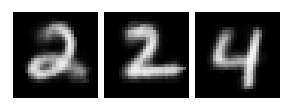

In [13]:
x1 = pretrained_model.decode(z1.to(device)) # red
x2 = pretrained_model.decode(z2.to(device)) # green 
x3 = pretrained_model.decode(z3.to(device)) # blue

x_img = make_grid(
    torch.cat([x1, x2, x3], dim=0).detach().cpu(), 
    nrow=3, value_range=(0, 1), pad_value=1)

plt.figure(figsize=(5,5))
plt.imshow(x_img.permute(1,2,0))
plt.axis('off')
plt.show()


- Compute the lengths of two curves, red2green and red2blue straight lines, by using the "compute_length_of_curve" function.

In [14]:
num_discretization = 100
z12_linear_curve = torch.cat([z1.to(device) + (z2.to(device) - z1.to(device)) * t/(num_discretization-1) for t in range(num_discretization)], dim=0)
z13_linear_curve = torch.cat([z1.to(device) + (z3.to(device) - z1.to(device)) * t/(num_discretization-1) for t in range(num_discretization)], dim=0)

L12 = compute_length_of_curve(
    z12_linear_curve
    , pretrained_model, get_Riemannian_metric)
L13 = compute_length_of_curve(
    z13_linear_curve
    , pretrained_model, get_Riemannian_metric)
L12, L13

(tensor(11.3468, device='cuda:0'), tensor(15.6697, device='cuda:0'))

Q3) Which curve is longer? Why?

A3) The curve L13 is longer. Since it crosses the boundary, which means the Rimannian metric along that curve is larger.

In [15]:
from scipy.optimize import minimize

(c) Write the code for finding the geodesic curve that connects two points $z_1, z_2 \in \mathbb{R}^2$ by using your "get_Riemannian_metric" function (you may want to use some python library for optimization, e.g., scipy.optimize.minimize, and use one of the gradient-based methods for fast optimization).

In [16]:
def compute_geodesic(z1, z2, pretrained_model, get_Riemannian_metric, num_discretization=100):
    '''
    z1 : torch.tensor whose size = (1, 2)
    z1 : torch.tensor whose size = (1, 2)
    out: torch.tensor whose size = (num_discretization, 2)
    '''
    sdz = (z2-z1)/num_discretization
    _curve = [z1 + sdz*i for i in range(100)]
    curve = None
    for i in range(100):
        if curve == None:
            curve = _curve[i]
        else:
            #print(type(curve), type(_curve[i]), curve.shape, _curve[i].shape)
            curve = torch.cat([curve, _curve[i]])
        curve = curve.to(device)
    step =  compute_length_of_curve(curve, pretrained_model, get_Riemannian_metric) / num_discretization
    #print("Linear_Curve dist is: ", step.cpu().numpy() * num_discretization)
    def G_ds(dz):
        #print(dz, G)
        out = np.expand_dims(dz,axis=0)@(G.cpu().numpy()@np.expand_dims(dz,axis= 1))
        out = np.squeeze(out)
        out = np.squeeze(out)
        #print("out", out.shape) 
        return out
    def con(dz):
        return step.cpu().numpy() - np.sqrt(G_ds(dz))
    def func(dz):
        return np.linalg.norm(z2.cpu().numpy() - z - dz)
    cons = [{'type':'ineq', 'fun': con}]

    ##############################################
    ############### YOUR CODE HERE ###############
    ##############################################
    z = z1.cpu().numpy()
    out = np.zeros((num_discretization, 2))
    out[0] = z
    for i in range(num_discretization-1):
        G = get_Riemannian_metric(pretrained_model.decode, torch.tensor(z, dtype = torch.float32).to(device))
        #init_dz = torch.tensor([1,0]).to(device)
        init_dz = np.array([1,0])
        init_dz = init_dz / G_ds(init_dz) * step.cpu().numpy()
        #init_dz = init_dz.cpu().numpy()
        dz = minimize(func, init_dz, constraints=cons)
        #print('current z: ',z, 'objective: ',z2.cpu().numpy() ,' index: ',i)
        z = z + np.array(dz['x'])
        if (func(0) < 0.001): z = z2.cpu().numpy()
        out[i+1] = z
    out[-1] = z2.cpu().numpy()
    print(out.shape)
    out = torch.tensor(out, dtype = torch.float32).to(device)
    return out

- Your code should pass the below test code.

In [17]:
z1 = torch.tensor([[-1, 1]], dtype=torch.float32) 
z2 = torch.tensor([[0.6, -1.2]], dtype=torch.float32) 

num_discretization = 100
z12_geodesic_curve = compute_geodesic(
    z1.to(device), 
    z2.to(device), 
    pretrained_model, 
    get_Riemannian_metric, 
    num_discretization=num_discretization
)
assert z12_geodesic_curve.size() == torch.Size([num_discretization, 2])

(100, 2)


- Compute the lengths of the geodesic curve (i.e., geodesic distances).

In [18]:
L12 = compute_length_of_curve(
    z12_geodesic_curve.to(device), pretrained_model, get_Riemannian_metric)
L12

tensor(42.2845, device='cuda:0')

- Let's compare the geodesic and linear interpolation results.
- The gray line is the linear interpolation in the latent space and the pink line is the geodesic interpolation. 

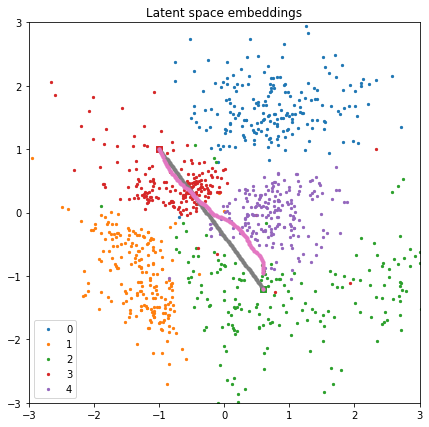

In [19]:
z12_linear_curve = torch.cat([z1.to(device) + (z2.to(device) - z1.to(device)) * t/(num_discretization-1) for t in range(num_discretization)], dim=0)

latent_embeddings = pretrained_model.encode(
    train_ds.data.to(device)
    ).detach().cpu().numpy()

z_scale = np.minimum(
    np.max(latent_embeddings, axis=0), 
    np.min(latent_embeddings, axis=0)
)
labels = torch.unique(train_ds.targets)

f = plt.figure(figsize=(7, 7))
plt.title('Latent space embeddings')
for label in labels:
    classwise_le = latent_embeddings[train_ds.targets == label]
    plt.scatter(
        classwise_le[:200, 0], 
        classwise_le[:200, 1], 
        label=label.item(), s=5)

plt.scatter(z1[0, 0], z1[0, 1], c='tab:red', marker='s')
plt.scatter(z2[0, 0], z2[0, 1], c='tab:green', marker='s')

plt.scatter(z12_linear_curve[:, 0].detach().cpu(), z12_linear_curve[:, 1].detach().cpu(), s=10, c='tab:gray')
plt.scatter(z12_geodesic_curve[:, 0].detach().cpu(), z12_geodesic_curve[:, 1].detach().cpu(), s=10, c='tab:pink')

plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.legend()
plt.show()

- Below visualizes the corresponding sequences of images.

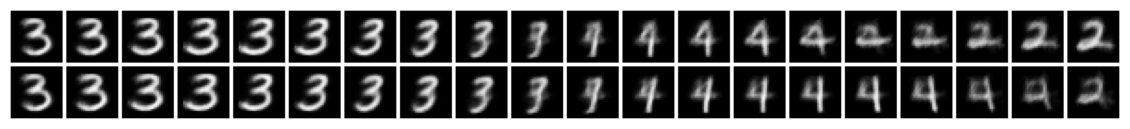

In [20]:
x12_linear_curve = pretrained_model.decode(z12_linear_curve)
x12_geodesic_curve = pretrained_model.decode(z12_geodesic_curve)

x_img = make_grid(
    torch.cat([
        x12_linear_curve[0:-1:5], 
        x12_geodesic_curve[0:-1:5]], dim=0).detach().cpu(), 
    nrow=20, value_range=(0, 1), pad_value=1)

plt.figure(figsize=(20,20))
plt.imshow(x_img.permute(1,2,0))
plt.axis('off')
plt.show()

Q4) How are they different? Why?

A4) As you see the trajectory, it moves much faster compared to that of  linear curve, Also, it moves along the boundary since when it moves along the tangent plane of boundary, the function varies little.

- Lastly, you will implement a clustering algorithm by using the geodesic distances and compare it with a usal Euclidean distance-based clustering algorithm in the latent sapce.
- We will use the SpectralClustering algorithm and only consider a subset of digit 2 and 4 images for simplicity. 

In [21]:
latent_embeddings = pretrained_model.encode(
    train_ds.data.to(device)
    ).detach().cpu()
data = []
targets = []
labels = [2, 4]

num_for_each_class = 20
for label in labels:
    classwise_le = latent_embeddings[train_ds.targets == label]
    data.append(classwise_le[:num_for_each_class])
    targets.append(train_ds.targets[train_ds.targets == label][:num_for_each_class])
data = torch.cat(data, dim=0)
targets = torch.cat(targets, dim=0)

In [ ]:
from sklearn.cluster import SpectralClustering

## Euclidean clustering
SC = SpectralClustering(n_clusters=2)
SC.fit(data)
Euclidean_est = torch.tensor(SC.labels_)

## Geodesic clustering
num_data = len(data)
tau = 10000
affinity_matrix = np.eye(num_data)
for i in range(num_data):
    for j in range(i+1, num_data):
        z1 = data[i:i+1]
        z2 = data[j:j+1]
        z12_geodesic_curve = compute_geodesic(
            z1.to(device), 
            z2.to(device), 
            pretrained_model, 
            get_Riemannian_metric, 
            num_discretization=100)
        dist = compute_length_of_curve(
            z12_geodesic_curve, pretrained_model, get_Riemannian_metric)
        affinity_matrix[i, j] = 2 * np.exp(-dist.item()**2/tau) 
        print(f'{i}-{j} done') 

affinity_matrix = (affinity_matrix + affinity_matrix.transpose())/2
SC = SpectralClustering(n_clusters=2, affinity='precomputed')
SC.fit(affinity_matrix)
Geodesic_est = torch.tensor(SC.labels_)

(100, 2)
0-1 done
(100, 2)
0-2 done
(100, 2)
0-3 done
(100, 2)
0-4 done
(100, 2)
0-5 done
(100, 2)
0-6 done
(100, 2)
0-7 done
(100, 2)
0-8 done
(100, 2)
0-9 done
(100, 2)
0-10 done
(100, 2)
0-11 done
(100, 2)
0-12 done
(100, 2)
0-13 done
(100, 2)
0-14 done
(100, 2)
0-15 done
(100, 2)
0-16 done
(100, 2)
0-17 done
(100, 2)
0-18 done
(100, 2)
0-19 done
(100, 2)
0-20 done
(100, 2)
0-21 done
(100, 2)
0-22 done
(100, 2)
0-23 done
(100, 2)
0-24 done
(100, 2)
0-25 done
(100, 2)
0-26 done
(100, 2)
0-27 done
(100, 2)
0-28 done
(100, 2)
0-29 done
(100, 2)
0-30 done
(100, 2)
0-31 done
(100, 2)
0-32 done
(100, 2)
0-33 done
(100, 2)
0-34 done
(100, 2)
0-35 done
(100, 2)
0-36 done
(100, 2)
0-37 done
(100, 2)
0-38 done
(100, 2)
0-39 done
(100, 2)
1-2 done
(100, 2)
1-3 done
(100, 2)
1-4 done
(100, 2)
1-5 done
(100, 2)
1-6 done
(100, 2)
1-7 done
(100, 2)
1-8 done
(100, 2)
1-9 done
(100, 2)
1-10 done
(100, 2)
1-11 done
(100, 2)
1-12 done
(100, 2)


In [ ]:
## plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for label in labels:
    classwise_le = data[targets == label]
    axes[0].scatter(
        classwise_le[:, 0], 
        classwise_le[:, 1], 
        label=label, s=20)
axes[0].set_title('ground truth class')

for label in [0, 1]:
    classwise_le = data[Euclidean_est == label]
    axes[1].scatter(
        classwise_le[:, 0], 
        classwise_le[:, 1], 
        label=label, s=20)
axes[1].set_title('Eucldiean clustering result')

for label in [0, 1]:
    classwise_le = data[Geodesic_est == label]
    axes[2].scatter(
        classwise_le[:, 0], 
        classwise_le[:, 1], 
        label=label, s=20)
axes[2].set_title('Geodesic clustering result')

Q5) Compare the results.

Geodescis clusting results are better since it reflects the manifold M.

- To see more experiemnt results by using the latent space Riemannian metric, e.g., clustering with geodesic distances, chcek out the paper ["Latent Space Oddity: on the Curvature of Deep Generative Models"](https://arxiv.org/abs/1710.11379).